# Load Data

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms
# from torchsummary import summary
# Misc
import time
from datetime import datetime
# preprocessing 
import av
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
data_dir = "dataset"
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'

In [4]:
# All labels
filtered_data = "data"
train_label_df = pd.read_csv(f'{filtered_data}/train.csv', header=None)
test_label_df = pd.read_csv(f'{filtered_data}/test.csv', header=None)
val_label_df = pd.read_csv(f'{filtered_data}/val.csv', header=None)

# convert all into hashmap - key = u_vid_name , value = label

train_label = {f"{train_dir}/{k[0]}": k[1] for k in train_label_df.values.tolist()}
test_label = {f"{test_dir}/{k[0]}": k[1] for k in test_label_df.values.tolist()}
val_label = {f"{val_dir}/{k[0]}": k[1] for k in val_label_df.values.tolist()}

In [5]:
# Total label + turkish to english translation

total_label = pd.read_csv(f'{filtered_data}/filtered_ClassId.csv')
u_len_label = len(total_label['ClassId'].unique())
print("total unique label:", u_len_label)


total unique label: 10


# Preprocessing

In [6]:
def extract_frames(vid_path, frames_cap, transforms=None):
    """Extract and transform video frames

    Parameters:
    vid_path (str): path to video file
    frames_cap (int): number of frames to extract, evenly spaced
    transforms (torchvision.transforms, optional): transformations to apply to frame

    Returns:
    list of numpy.array: vid_arr

    """
    vid_arr = []
    with av.open(vid_path) as container:
        stream = container.streams.video[0]
        n_frames = stream.frames
        remainder = n_frames % frames_cap
        interval = n_frames // frames_cap
        take_frame_idx = 0
        for frame_no, frame in enumerate(container.decode(stream)):
            if frame_no == take_frame_idx:
                img = frame.to_image()
                if transforms:
                    img = transforms(img)
                vid_arr.append(np.array(img))
                if remainder > 0:
                    take_frame_idx += 1
                    remainder -= 1
                take_frame_idx += interval
    if len(vid_arr) < frames_cap:
        raise ValueError(f"video with path '{vid_path}' is too short, please make sure that video has >={frames_cap} frames")
    return vid_arr

In [7]:
# mask rbg image
def masking(rbg_arr, depth_arr):
    """
    input
        - path for rbg
        - path for depth
    output
        - array of numpy arrays
    """

    # display - correct color orientation
    overlay_arr = []
    for i in range(len(rbg_arr)):
        # c = cv2.cvtColor(rbg_arr[i], cv2.COLOR_BGR2RGB)
        c = cv2.cvtColor(rbg_arr[i], cv2.COLOR_BGR2GRAY)

        gray = cv2.cvtColor(depth_arr[i], cv2.COLOR_BGR2GRAY)
        overlay = cv2.bitwise_and(c,c, mask= gray)
        overlay_arr.append(overlay)
    
    overlay_np_arr = np.array(overlay_arr)
    # print(overlay_np_arr.shape)
    overlay_np_arr = np.moveaxis(overlay_np_arr, -1, 1)
    # print(overlay_np_arr.shape)
    return overlay_np_arr

# Custom Dataset

In [8]:
class Turkish_Dataset(Dataset):
    def __init__(self, df, frames_cap, data_dir, file_ext=".mp4", transforms=None):
        self.df = df
        self.frames_cap = frames_cap
        self.transforms = transforms
        self.file_ext = file_ext
        self.data_dir = data_dir
    
    def __getitem__(self, index):

        vid_name = self.df.iloc[index, 0]
        vid_label = self.df.iloc[index, 1]
        
        vid_color = f"{self.data_dir}/{vid_name}_color{self.file_ext}"
        vid_depth = f"{self.data_dir}/{vid_name}_depth{self.file_ext}"

        # get videos
        rgb_arr = extract_frames(vid_color, self.frames_cap, transforms=self.transforms)
        depth_arr = extract_frames(vid_depth, self.frames_cap, transforms=self.transforms)

        vid_arr = np.stack((rgb_arr, depth_arr))
        vid_arr = np.moveaxis(vid_arr, 0, 1)
        
        # preprocessing
        # vid_arr = masking(rgb_arr, depth_arr)
        # print(vid_arr.shape)
        
        # create one-hot-encoding for label
        label = np.zeros(u_len_label)
        label[vid_label] = 1
        
        # convert arr to tensors
        vid_arr = torch.from_numpy(vid_arr).float()
        label = torch.from_numpy(label).float()
        
        # return masked video array and label
        return vid_arr, label
    
    def __len__(self):
        return len(self.df)

In [9]:
n_frames = 30
transforms_compose = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(200),
                                         transforms.Grayscale()])

shape of first array torch.Size([30, 2, 200, 200])


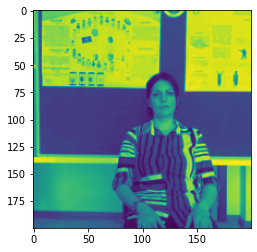

In [10]:
# Create train dataset

ld_train = Turkish_Dataset(train_label_df, n_frames, train_dir, transforms=transforms_compose)
print("shape of first array", ld_train[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_train[0][0][0][0].numpy()
plt.imshow(img_np_arr)
plt.show()

In [11]:
# # UNCOMMENT TO SEE SAMPLED FRAMES
# nrows, ncols = 6, 5
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
# for i in range(n_frames):
#     row_idx = i // ncols
#     col_idx = i % ncols
#     ax[row_idx][col_idx].imshow(ld_train[0][0][i][0].numpy())

# # # UNCOMMENT TO SAVE PLOT
# # plt.savefig('train_30_0.png')

# plt.show()

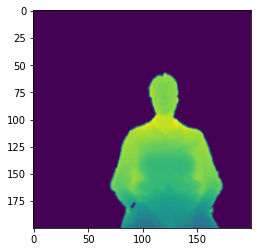

In [12]:
img_np_arr = ld_train[0][0][0][1].numpy()
plt.imshow(img_np_arr)
plt.show()

shape of first array torch.Size([30, 2, 200, 200])


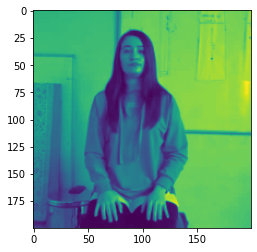

In [13]:
# Create test dataset

ld_test = Turkish_Dataset(test_label_df, n_frames, test_dir, transforms=transforms_compose)
print("shape of first array", ld_test[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_test[0][0][0][0].numpy()
plt.imshow(img_np_arr)
plt.show()

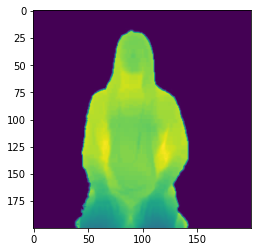

In [14]:
img_np_arr = ld_test[0][0][0][1].numpy()
plt.imshow(img_np_arr)
plt.show()

shape of first array torch.Size([30, 2, 200, 200])


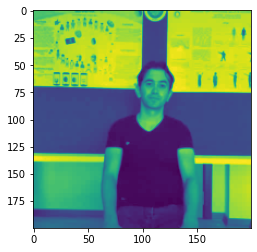

In [15]:
# Create val dataset

ld_val = Turkish_Dataset(val_label_df, n_frames, val_dir, transforms=transforms_compose)
print("shape of first array", ld_val[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_val[0][0][0][0].numpy()
plt.imshow(img_np_arr)
plt.show()

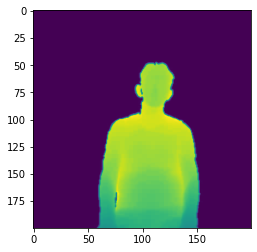

In [16]:
img_np_arr = ld_val[0][0][0][1].numpy()
plt.imshow(img_np_arr)
plt.show()

# Custom Dataloader

In [17]:
bs_train = 4
bs_test = 4
bs_val = 4
train_loader = DataLoader(ld_train, batch_size = bs_train, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_test, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

# Architecture

In [18]:
from models import CNN_RNN

In [19]:
model = CNN_RNN(u_len_label, 30, 1, 1, channel_in=2)

# Training

In [20]:
import model_fns

In [ ]:
train_loss_store, train_acc_store, val_loss_store, val_acc_store, val_metrics_store = model_fns.train(model, train_loader, val_loader, 2, device=device)
train_loss_store, train_acc_store, val_loss_store, val_acc_store, val_metrics_store

# Graph

In [22]:
# # UNCOMMENT TO CLEAR GPU CACHE
# import gc
# gc.collect()
# torch.cuda.empty_cache()